# How to use prior knowledge in BottomUpParceLiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge, make_dot

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.16.2', '0.24.2', '0.11.1', '1.5.2']


## Utility function
We define a utility function to draw the directed acyclic graph.

In [2]:
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')
    
    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

## Test data
We create test data consisting of 6 variables.

In [3]:
np.random.seed(1000)

x6 = np.random.uniform(size=1000)
x3 = 2.0*x6 + np.random.uniform(size=1000)
x0 = 0.5*x3 + np.random.uniform(size=1000)
x2 = 2.0*x6 + np.random.uniform(size=1000)
x1 = 0.5*x0 + 0.5*x2 + np.random.uniform(size=1000)
x5 = 0.5*x0 + np.random.uniform(size=1000)
x4 = 0.5*x0 - 0.5*x2 + np.random.uniform(size=1000)

# The latent variable x6 is not included.
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T, columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

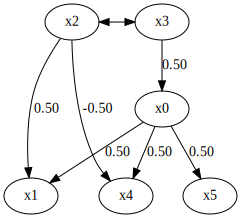

In [4]:
m = np.array([[0.0, 0.0,    0.0,    0.5, 0.0, 0.0],
              [0.5, 0.0,    0.5,    0.0, 0.0, 0.0],
              [0.0, 0.0,    0.0, np.nan, 0.0, 0.0],
              [0.0, 0.0, np.nan,    0.0, 0.0, 0.0],
              [0.5, 0.0,   -0.5,    0.0, 0.0, 0.0],
              [0.5, 0.0,    0.0,    0.0, 0.0, 0.0]])

make_dot(m)

## Make Prior Knowledge Matrix
We create prior knowledge so that x0, x1 and x4 are sink variables.

The elements of prior knowledge matrix are defined as follows:
* ``0`` : :math:`x_i` does not have a directed path to :math:`x_j`
* ``1`` : :math:`x_i` has a directed path to :math:`x_j`
* ``-1`` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.

In [5]:
prior_knowledge = make_prior_knowledge(
    n_variables=6,
    sink_variables=[0, 1, 4],
)
print(prior_knowledge)

[[-1  0 -1 -1  0 -1]
 [ 0 -1 -1 -1  0 -1]
 [ 0  0 -1 -1  0 -1]
 [ 0  0 -1 -1  0 -1]
 [ 0  0 -1 -1 -1 -1]
 [ 0  0 -1 -1  0 -1]]


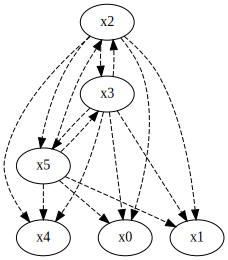

In [6]:
# Draw a graph of prior knowledge
make_prior_knowledge_graph(prior_knowledge)

## Causal Discovery
To run causal discovery using prior knowledge, we create a `DirectLiNGAM` object with the prior knowledge matrix.

In [7]:
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X)
print(model.causal_order_)
print(model.adjacency_matrix_)

[[0, 2, 3, 5], 4, 1]
[[ 0.     0.       nan    nan  0.       nan]
 [ 0.     0.     0.479  0.219  0.     0.212]
 [   nan  0.     0.       nan  0.       nan]
 [   nan  0.       nan  0.     0.       nan]
 [ 0.     0.    -0.494  0.212  0.     0.199]
 [   nan  0.       nan    nan  0.     0.   ]]


We can see that x0, x1, and x4 are output as sink variables, as specified in the prior knowledge.

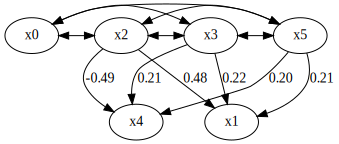

In [8]:
make_dot(model.adjacency_matrix_)

Next, let's specify the prior knowledge so that x0 is an exogenous variable.

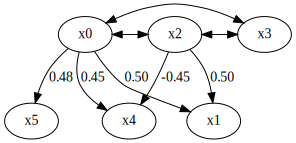

In [9]:
prior_knowledge = make_prior_knowledge(
    n_variables=6,
    exogenous_variables=[0],
)

model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X)

make_dot(model.adjacency_matrix_)